### CNN built with Keras
It largely follows the example from the Keras' Github, with my own modifications. The network architecture was proposed by Yan LeCun in the 1990s.
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
<br>
Also see Keras' blog.
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


#### Directory structure used in the project
##### Testing
/Users/valentin/GoogleDrive/Brikz/images/test/train
<br>
/Users/valentin/GoogleDrive/Brikz/images/test/validate
##### Development
/Users/valentin/GoogleDrive/Brikz/images/train
<br>
/Users/valentin/GoogleDrive/Brikz/images/validate

In [604]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras import backend as K
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import os
import cv2

%matplotlib inline

# Location of images (use test folder to setup the architecture and process)
train_data_dir = "C:/Users/bre49823/GoogleDrive/Brikz/images/test/train"         # "/Users/valentin/GoogleDrive/Brikz/images/test/train"
validation_data_dir = "C:/Users/bre49823/GoogleDrive/Brikz/images/test/validate"    # "/Users/valentin/GoogleDrive/Brikz/images/test/validate"

# Assign dimensions of our images
img_width, img_height, img_depth = 150, 150, 3
img_classes = 2

# Parameters for the network
epochs = 50
batch_size = 8

# "inputShape" is necessary to properly order the parameters
# If using the Tensorflow backend for Keras, the ordering is "channels last"
# The ordering for the Theano backend is "channels first"
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

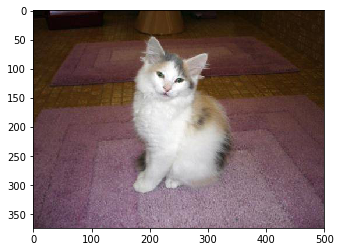

In [605]:
# Check the photos in the directory - plot random images
dir_img = train_data_dir + "/non_brikz/"
list_img = os.listdir(dir_img)
read_img = mpimg.imread(dir_img + list_img[1])
#read_img = mpimg.imread(dir_img + list_img[random.randint(0, len(list_img)) - 1]) # / 255 # Normalize by dividing by 255

#print(read_img) # print out the image data

plt.imshow(read_img)

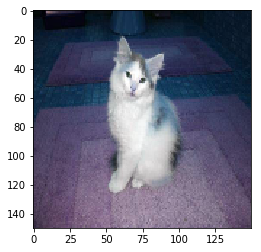

In [606]:
# Check how the image depth and height impact the original images
dir_img = train_data_dir + "/non_brikz/"
list_img = os.listdir(dir_img)
tt = cv2.imread(dir_img + list_img[1])
tt = cv2.resize(tt, (img_width, img_height))
plt.imshow(tt)

In [607]:
data = []
labels = []

# Grab the image paths for the cases and non_cases and randomly shuffle them
random.seed(7894)
imagePaths_cases = [(train_data_dir + "/brikz/" + x) for x in os.listdir(train_data_dir + "/brikz/")]
imagePaths_noncases = [(train_data_dir + "/non_brikz/" + x) for x in os.listdir(train_data_dir + "/non_brikz/")]
imagePaths = imagePaths_cases + imagePaths_noncases
random.shuffle(imagePaths)

# Loop over the images to resize them
for imagePath in imagePaths:
    # Load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (img_width, img_height))
    image = img_to_array(image)
    data.append(image)

    # Extract the class label from the image path and update the labels list
    label = imagePath.split("/")[-2]
    label = 1 if label == "brikz" else 0
    labels.append(label)

In [608]:
# Scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype = "float") / 255.0
labels = np.array(labels)

# Partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size = 0.25, random_state = 42)

# Normalization - scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype = "float") / 255.0
labels = np.array(labels)

In [609]:
trainX.shape

(18, 150, 150, 3)

In [610]:
# Convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes= 2)
testY = to_categorical(testY, num_classes = 2)

In [611]:
# Data augmentation - Use augmentation when there are few images to work with
# Only augment the training images, do NOT augment the validation images
# For more on the augmentation tools in Keras, read this https://keras.io/preprocessing/image/

# Create an image generator to augment the small set of images I have
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

# Augment the validatione data - ONLY rescaling. DO NOT apply other types of image modifications on the validation data
validation_datagen = ImageDataGenerator(rescale = 1. / 255)

In [614]:
# Specify the input shape for the image arrays
input_shape = (img_height, img_width, img_depth)

# Network architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("sigmoid")) # The LeCun network is with "sigmoid" instead of "softmax"

# Since this is a two-class classification problem we’ll want to use binary cross-entropy as our loss function
# If you are performing classification with > 2 classes, be sure to swap out the loss  for categorical_crossentropy
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [615]:
brikz_model = model.fit_generator(train_datagen.flow(trainX, trainY, batch_size = batch_size),
                                  validation_data = (testX, testY),
                                  steps_per_epoch = len(trainX) // batch_size,
                                  epochs = epochs,
                                  verbose = 1)

# Save the weights
brikz_model.model.save_weights("C:/Users/bre49823/GoogleDrive/Brikz/brikz_model/first_try.h5")

Epoch 1/50
2/2 [==============================] - 1s - loss: 0.5488 - acc: 0.6875 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 2/50
2/2 [==============================] - 0s - loss: 7.0267e-07 - acc: 1.0000 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 3/50
2/2 [==============================] - 0s - loss: 2.3668 - acc: 0.8500 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 4/50
2/2 [==============================] - 1s - loss: 0.4378 - acc: 0.8750 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 5/50
2/2 [==============================] - 0s - loss: 0.3826 - acc: 0.9250 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 6/50
2/2 [==============================] - 0s - loss: 0.2951 - acc: 0.9250 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 7/50
2/2 [==============================] - 1s - loss: 0.7478 - acc: 0.8750 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 8/50
2/2 [==============================] - 0s - loss: 0.3390 - acc: 0.9250 - val_loss: 5.3434 - val_acc: 0.6667
Epoch 9/50
2/2 [============================

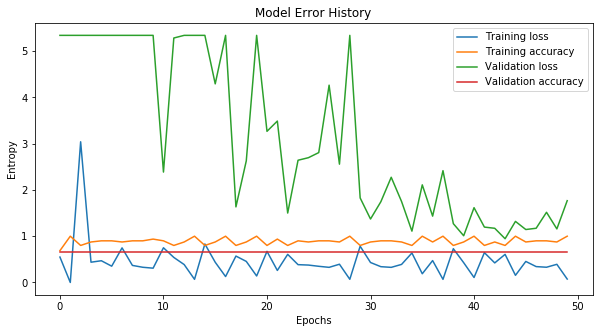

In [616]:
# Plot the errors of the epochs and MSE
plt.figure(figsize = (10, 5))
plt.plot(brikz_model.history["loss"], label = "Training loss")
plt.plot(brikz_model.history["acc"], label = "Training accuracy")
plt.plot(brikz_model.history["val_loss"], label = "Validation loss")
plt.plot(brikz_model.history['val_acc'], label = "Validation accuracy")

plt.title('Model Error History')
plt.ylabel('Entropy')
plt.xlabel('Epochs')
plt.legend(loc = "upper right")
plt.show()

0.995504 0.0048377


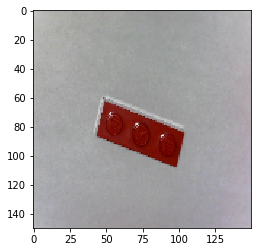

In [617]:
# Select random image examples from training and validation and check model accuracy
# Train
#C:\Users\bre49823\GoogleDrive\Brikz\images\test\train\brikz
#C:\Users\bre49823\GoogleDrive\Brikz\images\test\train\non_brikz  

# Validate
#C:\Users\bre49823\GoogleDrive\Brikz\images\test\validate\brikz
#C:\Users\bre49823\GoogleDrive\Brikz\images\test\validate\non_brikz

dir_img = "C:/Users/bre49823/GoogleDrive/Brikz/images/test/validate/brikz/"
list_img = os.listdir(dir_img)
read_img = mpimg.imread(dir_img + list_img[random.randint(0, len(list_img)) - 1])

# Pre-process the image for classification
orig = read_img.copy()
image = cv2.resize(orig, (img_width, img_height))
image2 = image.astype("float") / 255.0
image2 = img_to_array(image2)
image2 = np.expand_dims(image2, axis = 0)

#image2.shape # The convolutional layer in the network expects that the input image is an array, even if it's an array with a single element. See https://stackoverflow.com/questions/41563720/error-when-checking-model-input-expected-convolution2d-input-1-to-have-4-dimens

brikz, non_brikz = brikz_model.model.predict(image2)[0]

print(brikz, non_brikz)
plt.imshow(image)